In [1]:
fig_dir = "../../figures/"
fig_ext = "pdf"

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

This notebook is designed to carry out some tests on the HERON hodlr model trainged off the Georgia Tech waveforms (Lomond).

In [3]:
import thesis
from thesis.heron import *

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/heron-stable/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import heron.models.georgebased
import numpy as np
generator = heron.models.georgebased.HeronHodlr(exclude_waveforms=[u'GT0760', u'GT0748', u'GT0757', u'GT0622', u'GT0758', u'GT0654', u'GT0653', u'GT0565', u'GT0884', u'GT0875', u'GT0651'])

Skipped waveform GT0875
Skipped waveform GT0622
Skipped waveform GT0884
Skipped waveform GT0565
Skipped waveform GT0748
Skipped waveform GT0758
Skipped waveform GT0651
Skipped waveform GT0757
Skipped waveform GT0654
Skipped waveform GT0760
Skipped waveform GT0653


In [5]:
#heron.models.georgebased.train(generator, max_iter=100000, batch_size=100)

In [6]:
import elk
total_mass = generator.total_mass
imr_cat = elk.catalogue.PPCatalogue("IMRPhenomPv2", 
                                    total_mass=total_mass, 
                                    fmin=95)
seo_cat = elk.catalogue.PPCatalogue("SEOBNRv4_ROM", 
                                    total_mass=total_mass, 
                                    fmin=95)
seo3_cat = elk.catalogue.PPCatalogue("SEOBNRv3", 
                                    total_mass=10, 
                                    fmin=95)
nrsur_cat = elk.catalogue.PPCatalogue("NRSur7dq2", 
                                    total_mass=10, 
                                    fmin=95)

In [7]:
rows = generator.catalogue.table
results = {}

In [8]:
data = pd.read_json("../../data/heron/gt-in-matches.json")
approx_results = data.to_dict(orient="index")

In [ ]:
approx_results = {}
# Calculate the various matches with surrogate models
for row in rows.iterrows():
    
    row = row[1]
    
    if row['tag'] in ["GT063{}".format(i) for i in range(10)] + ["GT0701", "GT0881", "GT0833"]: 
        continue
    
    if row['tag'] in approx_results.keys():
        continue
    
    p = {"mass ratio": row['mass_ratio'],
        "spin 1x": row['spin_1x'], "spin 1y": row['spin_1y'], "spin 1z": row['spin_1z'],
        "spin 2x": row['spin_2x'], "spin 2y": row['spin_2y'], "spin 2z": row['spin_2z']
        }
    
    if row['tag'] in ["GT063{}".format(i) for i in range(10)] + ["GT0701"]: 
        continue
    
    try:
        waveform = [x  for x in generator.catalogue.waveforms if x.tag == row['tag'] ][0]

        
        print("Using NR waveform {}".format(row['tag']))
        
        nr_timeseries = waveform.timeseries(total_mass=60, f_low=70, t_max=0.02, t_min=-0.015)
        times = nr_timeseries[0].times
        
        print("\t+Generating mean GPR waveform")

        tdwave = generator.mean(p.copy(), times=times.copy())

        time_range = [times[0], times[-1], len(times)]
        #
        print("\t+Generating approximant waveforms")
        a = imr_cat.waveform(time_range=time_range, p=p.copy())
        time_range[0] /=6
        time_range[1] /=6
        b = seo3_cat.waveform(time_range=time_range, p=p.copy())
        
        b[0].times *= 6
        b[0].data *=6
        b[0].dt = b[0].times[1] - b[0].times[0]

        td_pad = np.pad(tdwave[0].data, (len(a[0].data) - len(tdwave[0].data))/2, "constant", constant_values=0)
        tdwave[0].data = td_pad
        tdwave[0].times = a[0].times
        
        nr_pad = np.pad(nr_timeseries[0].data, (len(a[0].data) - len(nr_timeseries[0].data))/2, 
                        "constant", constant_values=0)
        nr_timeseries[0].data = nr_pad
        nr_timeseries[0].times = a[0].times
        
        
        
        nr_gp_match = match(nr_timeseries[0], tdwave[0])
        print("\tNR match with GP: {}".format(nr_gp_match[0]))
        imr_match = match(a[0], nr_timeseries[0])
        print("\tNR match with IMR: {}".format(imr_match[0]))
        seo_match = match(b[0], nr_timeseries[0])
        print("\tNR match with SEO: {}".format(seo_match[0]))
        imr_gp_match = match(a[0], tdwave[0])
        print("\tGP match with IMR: {}".format(imr_gp_match[0]))
        seo_gp_match = match(b[0], tdwave[0])
        print("\tGP match with SEO: {}".format(seo_gp_match[0]))
        approx_results[row['tag']] ={
                        "waveform": row['tag'], 
                        #"parameters": p, 
                        "nr gp match": nr_gp_match[0], 
                        "imr gp match": imr_gp_match[0], 
                        "seo gp match": seo_gp_match[0],
                        "imr nr match": imr_match[0], 
                        "seo nr match": seo_match[0],
                       }
    except:
        pass
    
    results_df = pd.DataFrame.from_dict(approx_results, orient='index')
    results_df.to_json("in-sample-matches-short.json")

Using NR waveform GT0371
	+Generating mean GPR waveform
	+Generating approximant waveforms
	NR match with GP: 0.889100700034
	NR match with IMR: 0.96796486711
	NR match with SEO: 0.982962607172
	GP match with IMR: 0.887038778319
	GP match with SEO: 0.879833387761
Using NR waveform GT0670
	+Generating mean GPR waveform
	+Generating approximant waveforms
	NR match with GP: 0.999727896737
	NR match with IMR: 0.970731155828
	NR match with SEO: 0.950031666416
	GP match with IMR: 0.970493101643
	GP match with SEO: 0.952951214445
Using NR waveform GT0628
	+Generating mean GPR waveform
	+Generating approximant waveforms
	NR match with GP: 0.997763690317
	NR match with IMR: 0.914998852114
	NR match with SEO: 0.930595786186
	GP match with IMR: 0.916287460752
	GP match with SEO: 0.936606158477
Using NR waveform GT0428
	+Generating mean GPR waveform
	+Generating approximant waveforms
Using NR waveform GT0732
	+Generating mean GPR waveform


In [9]:
len(generator.catalogue.table)

132

In [10]:
results_df = pd.read_json("../../data/heron/gt-in-matches.json")
catalogue = generator.catalogue.table
catalogue = catalogue.set_index("tag")
combined = results_df.join(catalogue)

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/heron-stable/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/heron-stable/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u"'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


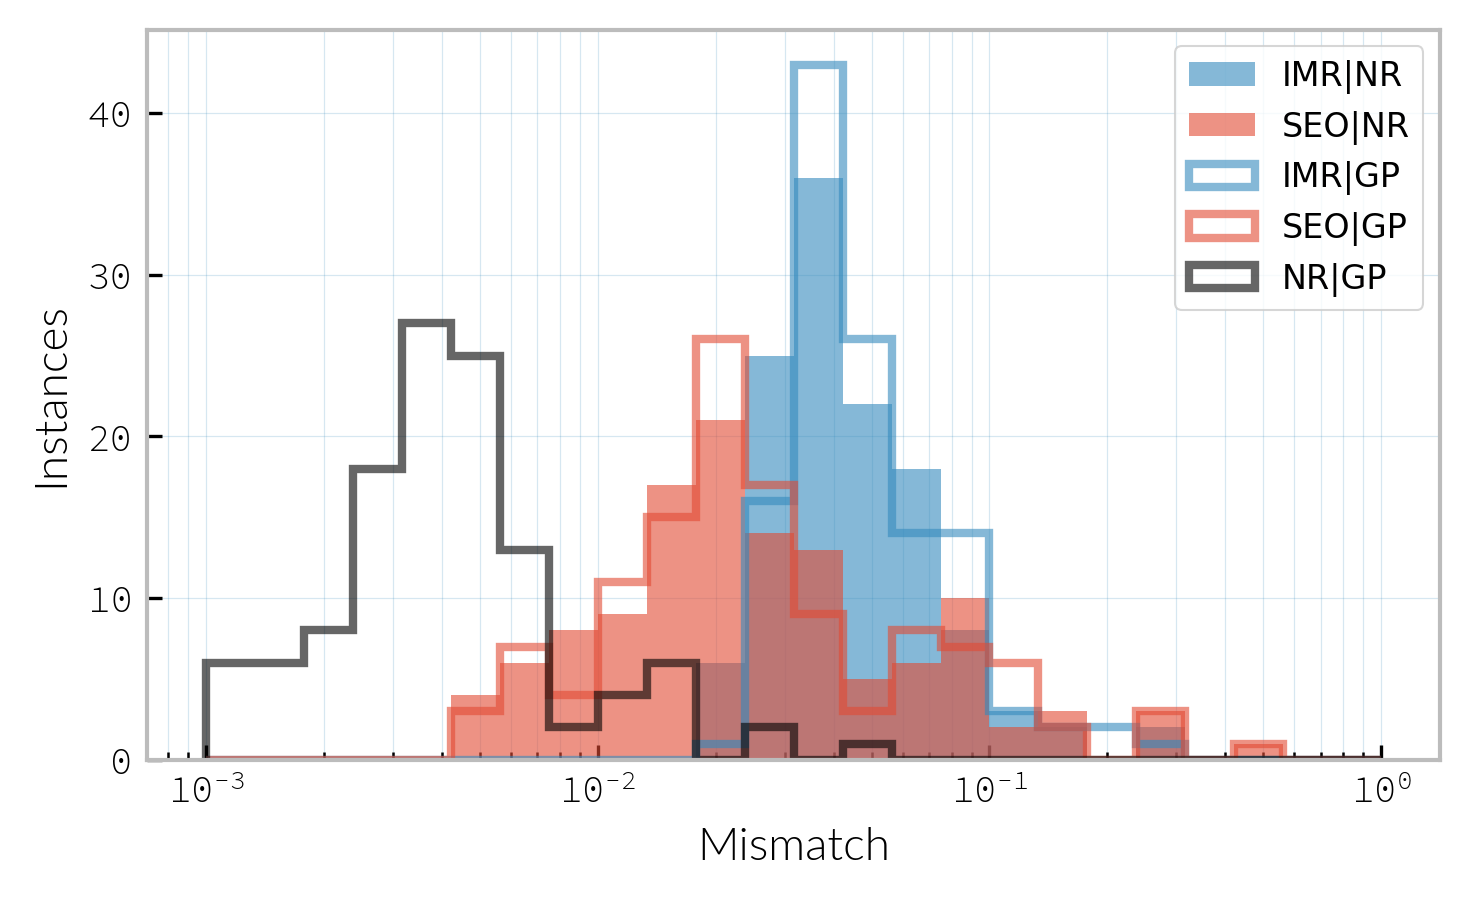

In [11]:
f, ax = plt.subplots(1,1, dpi=300)


ax.set_xscale("log")
ax.hist(1-combined['imr nr match'], bins=np.logspace(-3,0, 25), alpha=0.6, label="IMR|NR", fc="#348ABD")
ax.hist(1-combined['seo nr match'], bins=np.logspace(-3,0, 25), alpha=0.6, label="SEO|NR", fc="#E24A33")

ax.hist(1-combined['imr gp match'], bins=np.logspace(-3,0, 25), alpha=0.6, label="IMR|GP", ec="#348ABD", lw=2, histtype="step")
ax.hist(1-combined['seo gp match'], bins=np.logspace(-3,0, 25), alpha=0.6, label="SEO|GP", ec="#E24A33", lw=2, histtype="step")

ax.hist(1-combined['nr gp match'], bins=np.logspace(-3,0, 25), alpha=0.6, label="NR|GP", histtype="step", lw=2, 
        ec='k')
plt.legend()

ax.set_xlabel("Mismatch")
ax.set_ylabel("Instances")

f = thesis.thesisify(f)

f.savefig("{}/heron/in-sample-hist.{}".format(fig_dir, fig_ext))

In [12]:
approx_results = {}
#data = pd.read_json("out-sample-matches.json")
#approx_results = data.to_dict(orient="index")
for row in rows.iterrows():
    
    row = row[1]
    
    if row['tag'] in approx_results.keys():
        continue
    
    if row['tag'] in ["GT063{}".format(i) for i in range(10)] + ["GT0701", "GT0881", "GT0833"]: 
        continue
    
    p = {"mass ratio": row['mass_ratio'],
        "spin 1x": row['spin_1x'], "spin 1y": row['spin_1y'], "spin 1z": row['spin_1z'],
        "spin 2x": row['spin_2x'], "spin 2y": row['spin_2y'], "spin 2z": row['spin_2z']
        }
    
    
    
    try:
        print("Using NR waveform {}".format(row['tag']))
        waveform = [x  for x in generator.catalogue.waveforms if x.tag == row['tag'] ][0]

        nr_timeseries = waveform.timeseries(total_mass=60, f_low=70, t_max=0.02, t_min=-0.015, )
        times = nr_timeseries[0].times
        time_range = [times[0], times[-1], len(times)]
        
        tdwave = generator.mean(p.copy(), times=times.copy())
        
        #samples = generator.distribution(p.copy(), times=times.copy(), samples=100)
        print("\t+Generating LOO model")
        generator_loo = heron.models.georgebased.HeronHodlr(exclude_waveforms=["{}".format(row['tag'])])

        tdwave2 = generator_loo.mean(p.copy(), times=times.copy())
        
        print("\t+Generating approximant waveforms")
        a = imr_cat.waveform(time_range=time_range, p=p.copy())
        time_range[0] /=6
        time_range[1] /=6
        b = seo3_cat.waveform(time_range=time_range, p=p.copy())
        
        b[0].times *= 6
        b[0].data *=6
        b[0].dt = b[0].times[1] - b[0].times[0]

        td_pad = np.pad(tdwave2[0].data, (len(a[0].data) - len(tdwave2[0].data))/2, "constant", constant_values=0)
        tdwave2[0].data = td_pad
        tdwave2[0].times = a[0].times
        
        nr_pad = np.pad(nr_timeseries[0].data, (len(a[0].data) - len(nr_timeseries[0].data))/2, 
                        "constant", constant_values=0)
        nr_timeseries[0].data = nr_pad
        nr_timeseries[0].times = a[0].times
        
        
        in_out_match = match(tdwave[0], tdwave2[0])
        nr_gp_match = match(nr_timeseries[0], tdwave2[0])
        print("\tNR match with GP: {}".format(nr_gp_match[0]))
        imr_gp_match = match(a[0], tdwave2[0])
        print("\tGP match with IMR: {}".format(imr_gp_match[0]))
        seo_gp_match = match(b[0], tdwave2[0])
        print("\tGP match with SEO: {}".format(seo_gp_match[0]))
        approx_results[row['tag']] ={
                        "in out match": in_out_match[0],
                        "nr gp match out": nr_gp_match[0], 
                        "imr gp match out": imr_gp_match[0], 
                        "seo gp match out": seo_gp_match[0],
                       }

    except elk.exceptions.LalsuiteError:
        pass
    out_results_df = pd.DataFrame.from_dict(approx_results, orient='index')
    out_results_df.to_json("../../data/heron/gt-out-matches.json")

Using NR waveform GT0371
	+Generating LOO model
Skipped waveform GT0371
	+Generating approximant waveforms
	NR match with GP: 0.889100700034
	GP match with IMR: 0.887038778319
	GP match with SEO: 0.879833387761
Using NR waveform GT0670
	+Generating LOO model
Skipped waveform GT0670
	+Generating approximant waveforms
	NR match with GP: 0.999727896737
	GP match with IMR: 0.970493101643
	GP match with SEO: 0.952951214445
Using NR waveform GT0628
	+Generating LOO model
Skipped waveform GT0628
	+Generating approximant waveforms
	NR match with GP: 0.997763690317
	GP match with IMR: 0.916287460752
	GP match with SEO: 0.936606158477
Using NR waveform GT0428
	+Generating LOO model
Skipped waveform GT0428


KeyboardInterrupt: 

In [ ]:
out_results_df = pd.DataFrame.from_dict(approx_results, orient='index')
out_results_df.to_json("../../data/heron/gt-out-matches.json")

In [16]:
results_df_out = pd.read_json("../../data/heron/gt-out-matches.json")#.add_suffix(' out')
catalogue = generator.catalogue.table
catalogue = catalogue.set_index("tag")
combined = results_df_out.join([catalogue])#, results_df_out])

In [17]:
from tabulate import tabulate

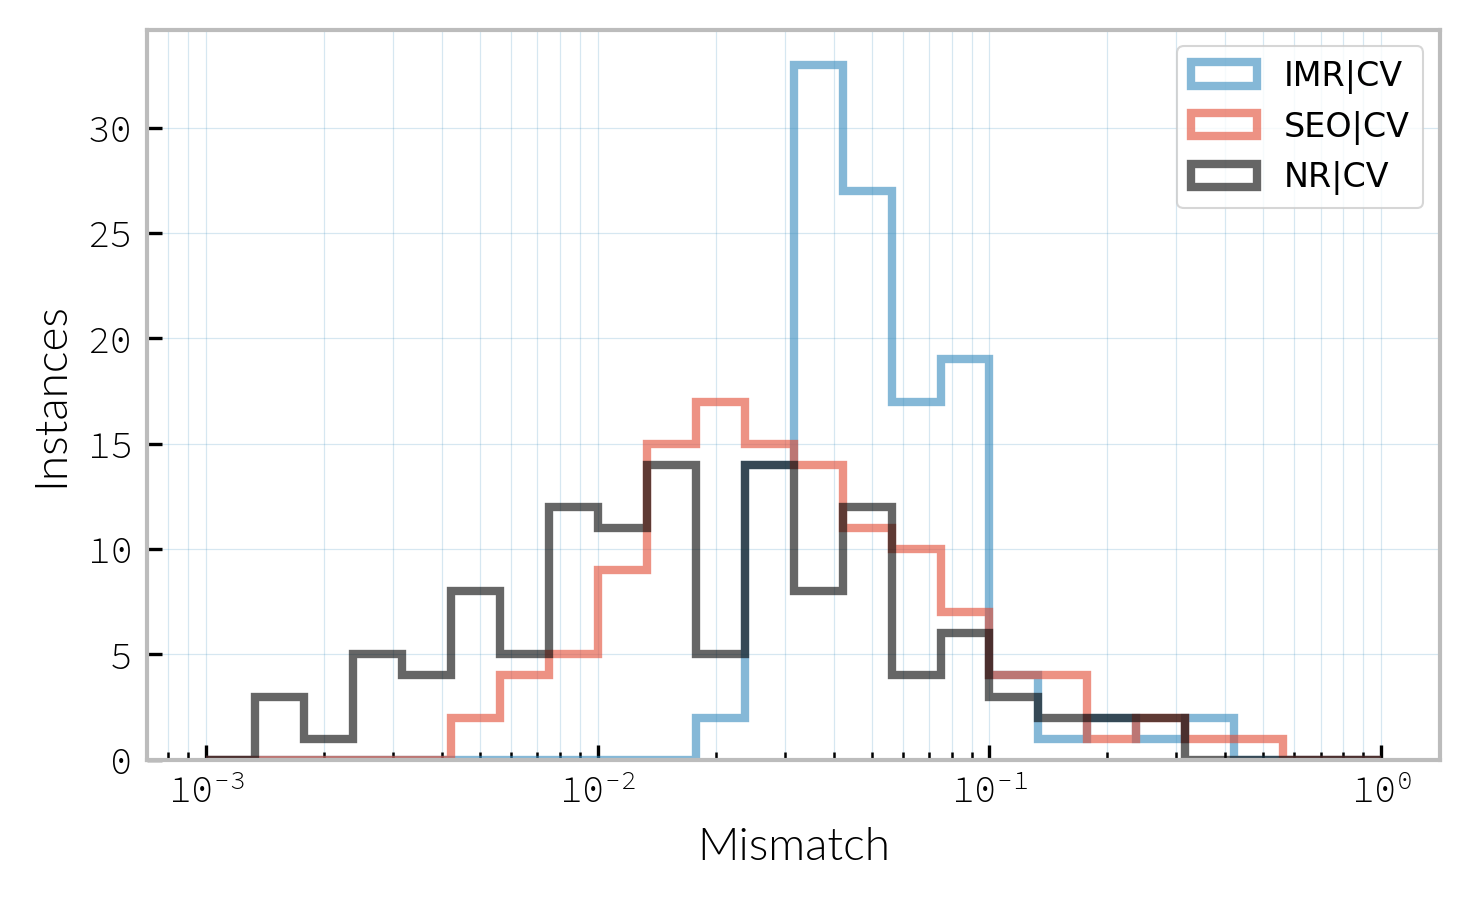

In [18]:
f, ax = plt.subplots(1,1, dpi=300)


ax.set_xscale("log")
#ax.hist(1-combined['imr nr match out'], bins=np.logspace(-3,0, 25), alpha=0.6, label="IMR|NR")
#ax.hist(1-combined['seo nr match'], bins=np.logspace(-3,0, 25), alpha=0.6, label="SEO|NR")

#ax.hist(1-combined['imr nr match'], bins=np.logspace(-3,0, 25), alpha=0.6, label="IMR|NR", fc="#348ABD")
#ax.hist(1-combined['seo nr match'], bins=np.logspace(-3,0, 25), alpha=0.6, label="SEO|NR", fc="#E24A33")

ax.hist(1-combined['imr gp match out'], bins=np.logspace(-3,0, 25), alpha=0.6, label="IMR|CV", histtype="step", lw=2, ec="#348ABD")
ax.hist(1-combined['seo gp match out'], bins=np.logspace(-3,0, 25), alpha=0.6, label="SEO|CV",histtype="step", lw=2,  ec="#E24A33")

ax.hist(1-combined['nr gp match out'], bins=np.logspace(-3,0, 25), alpha=0.6, label="NR|CV", histtype="step", lw=2, 
        ec='k')


plt.legend()

ax.set_xlabel("Mismatch")
ax.set_ylabel("Instances")

f = thesis.thesisify(f)

f.savefig("{}/heron/out-sample-hist.{}".format(fig_dir, fig_ext))

In [19]:
from scipy.spatial.distance import cdist
locs = combined[['mass_ratio', 'spin_1x', 'spin_1y', 'spin_1z', 'spin_2x', 'spin_2y', 'spin_2z']]
dmat = cdist(locs, locs)
np.fill_diagonal(dmat, np.nan)

combined['nearest'] = np.nanmin(dmat, axis=0)

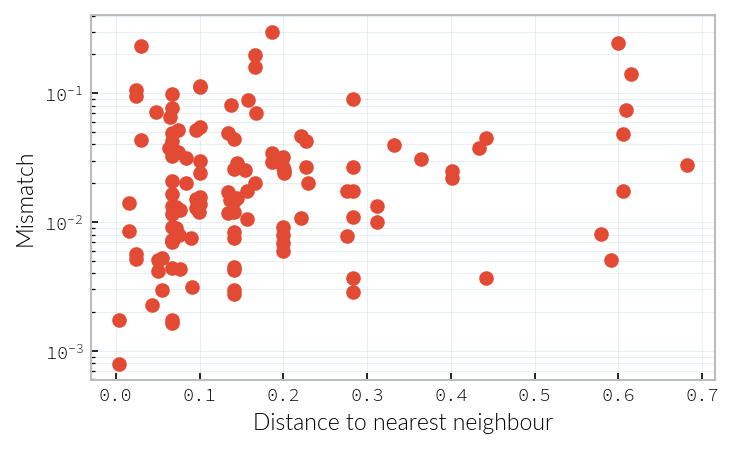

In [20]:
f, ax = plt.subplots(1,1, dpi=150)
#ax.plot(combined['nearest'], 1-combined['nr gp match'], 'o', label="IS")
ax.plot(combined['nearest'], 1-combined['nr gp match out'], 'o', label="CV")
ax.set_yscale("log")
ax.set_xlabel("Distance to nearest neighbour")
ax.set_ylabel("Mismatch")
#ax.legend(prop=thesis.ssp_legend)
thesis.thesisify(f)
f.savefig("{}/heron/ditance-v-mismatch-outsample.{}".format(fig_dir, fig_ext))

In [21]:
import astropy.constants as c

In [22]:
def samples_match(tag):

    
    cat = generator.catalogue.table.set_index("tag")
    row = cat.loc[tag]
    
    p = {"mass ratio": row['mass_ratio'],
        "spin 1x": row['spin_1x'], "spin 1y": row['spin_1y'], "spin 1z": row['spin_1z'],
        "spin 2x": row['spin_2x'], "spin 2y": row['spin_2y'], "spin 2z": row['spin_2z']
        }


    matches = []

    waveform = [x  for x in generator.catalogue.waveforms if x.tag == row.name ][0]
    wave = waveform.timeseries(total_mass=60, f_low=70, t_max=0.02, t_min=-0.015, )[0]

    samples = generator.distribution(p.copy(), times = wave.times.copy(), samples=100)
    for sample in samples:
        matches.append(match(sample, wave)[0])

    #mean = generator.mean(p.copy(), times = wave.times.copy())    
    
    return matches

In [23]:
import matplotlib.gridspec as gridspec
def paper_plot(p, phases=None, approximants=["IMRPhenomPv2", "SEOBNRv4"], matches_flag=True):
    width = 4.5
    height = 0.6*width/1.618

    
    time_factor = (c.c.value**3 / c.G.value)/(generator.total_mass*c.M_sun.value) #*1e4
    h_factor = c.pc.value
    
    f = plt.figure(constrained_layout=True, dpi=150)#, dpi=500)

    gs = gridspec.GridSpec(1,4, figure = f)

    time_range = [-0.0150, 0.0200, 1024]
    
    a = imr_cat.waveform(time_range=time_range, p=p.copy())
    
    
    time_range[0] /=6
    time_range[1] /=6
    b = seo3_cat.waveform(time_range=time_range, p=p.copy())

    b[0].times *= 6
    b[0].data *=6
    b[0].dt*=6
    
    samples = generator.distribution(p.copy(), times = a[0].times.copy(), samples=100)
    
    #samples = gp_cat.waveform_samples(p=p,
    #                              time_range=[-150., 100., 1024], samples=100)
    mean, variance = generator.mean(p.copy(), times = a[0].times.copy())
    
    
    if "IMRPhenomPv2" in approximants:
            matchimr, phaseimr = match(mean, a[0])
    if "SEOBNRv4" in approximants:
           matchseo, phaseseo = match(mean, b[0])
    
    print(matchimr, matchseo)
    
    ## Waveform plot
    times = samples[0].times #np.linspace(-150, 100, 1024)/1e4
    ##std = np.array(waveforms).std(axis=0)
    ax_wave = f.add_subplot(gs[0:3])
    ax_hist = f.add_subplot(gs[3])
    for sample in samples:
        ax_wave.plot(time_factor *sample.times, h_factor*sample.data, color='k', alpha=0.0525, lw=0.5)
    ax_wave.plot(time_factor * samples[0].times, h_factor * samples[0].data, color='k', alpha=0.0525, lw=0.5, label="GPR Draws")
    ax_wave.plot(time_factor * times, h_factor * mean.data, label = "GPR Mean", 
                 linestyle="--",
                 alpha=0.5, color='k', lw=2)
    ax_wave.fill_between(time_factor * times, h_factor *(mean.data + mean.variance/1e19), h_factor *(mean.data - mean.variance/1e19), alpha=0.1, color='k', label="GPR Variance")


            
    

    ##ax_wave.set_xlim([-0.01, 0.01])

    imr_matches = []
    seo_matches = []
    
    if matches_flag:
        #bb, ba = pycbc.waveform.coalign_waveforms(b[0].pycbc(), mean.pycbc())
        for sample in samples:
            if "IMRPhenomPv2" in approximants:
                ma = match(sample, a[0])
                imr_matches.append(ma[0])
                
            #if "SEOBNRv4" in approximants:
                seo_matches.append(match(sample, b[0])[0])
        
        if "IMRPhenomPv2" in approximants:
            ax_hist.hist(1.0 - np.array(imr_matches), 
                         range=(0,.25), 
                         density=True,
                         bins=21, 
                         histtype="stepfilled", 
                         alpha=0.4,
                         color="#348ABD",
                         label="IMRPhenomPv2"
                        )

        if "SEOBNRv4" in approximants:
            ax_hist.hist(1.0 - np.array(seo_matches), 
                     range=(0,.25), 
                     density=True,
                     bins=21, 
                     histtype="stepfilled", 
                     alpha=0.4,
                     color="#E24A33",
                     label="SEOBNRv3"
                    )
        ax_wave.set_xlabel("$(t-t_{merge}) / M$")#, fontdict=lato)
        ax_hist.set_xlabel("Mismatch")#, fontdict=lato)
        ax_wave.set_ylabel("$rh_{2,2}$") #, fontdict=lato)
        
    ax_hist.set_xscale("log")
        
    if "IMRPhenomPv2" in approximants:
        # IMRPhenomPv2
        waveform_imr = a[0]#(coa_phase=0, t0=0)[0]
        aa, ba = pycbc.waveform.coalign_waveforms(a[0].pycbc(), mean.pycbc())
        
        ax_wave.plot(time_factor *(aa.sample_times+mean.times[0]), h_factor*aa, label="IMRPhenomPv2", 
                     lw=2, alpha=0.8, color="#348ABD")
    if "SEOBNRv4" in approximants:
        # SEOBNRv4
        aa, ba = pycbc.waveform.coalign_waveforms(b[0].pycbc(), mean.pycbc())
        ax_wave.plot(time_factor *(aa.sample_times+mean.times[0]), h_factor*aa, label="SEOBNRv3", 
                      lw=2, alpha=0.8, color="#E24A33")
    
    ax_wave.set_xlim([-30, 50])
    ax_wave.legend(prop=thesis.ssp_legend)
    for label in ax_wave.get_xticklabels():
        label.set_fontproperties(thesis.ticks_font)
    for label in ax_wave.get_yticklabels():
        label.set_fontproperties(thesis.ticks_font)
    for label in ax_hist.get_xticklabels():
        label.set_fontproperties(thesis.ticks_font)
    for label in ax_hist.get_yticklabels():
        label.set_fontproperties(thesis.ticks_font)
    ax_hist.xaxis.get_offset_text().set_fontproperties(thesis.ticks_font)
    
    ax_hist.yaxis.get_offset_text().set_fontproperties(thesis.ticks_font)
    ax_wave.xaxis.get_offset_text().set_fontproperties(thesis.ticks_font)
    ax_wave.yaxis.get_offset_text().set_fontproperties(thesis.ticks_font)
    #f.tight_layout()
    #f = thesis.thesisify(f)
    ylims = ax_hist.get_ylim()
    ax_hist.vlines(1.-matchimr, *ylims, color="#348ABD")
    ax_hist.vlines(1.-matchseo, *ylims, color="#E24A33")
    ax_hist.set_ylim(*ylims)
    return f, [ax_wave, ax_hist], #{"imr": {"phase": phaseimr}, "seo": {"phase": phaseseo}}



In [24]:
import astropy.constants as c
time_factor = (c.c.value**3 / c.G.value)/(generator.total_mass*c.M_sun.value) #*1e4
h_factor = c.pc.value

In [25]:
waveform = [x  for x in generator.catalogue.waveforms if x.tag == "GT0374" ][0]
wave = waveform.timeseries(total_mass=60, f_low=None, t_min=-0.015, t_max=0.02)[0]

In [26]:
generator.gp.solver_kwargs['tol']=1e-2

In [27]:
vec = generator.gp.get_parameter_vector()
vec[0] = 0
vec[1] = np.log(0.001)
vec[2] = np.log(0.006)
generator.gp.set_parameter_vector(vec)
generator.gp.white_noise.set_parameter_vector([0])

(0.9704441704831263, 0.9856204107742819)


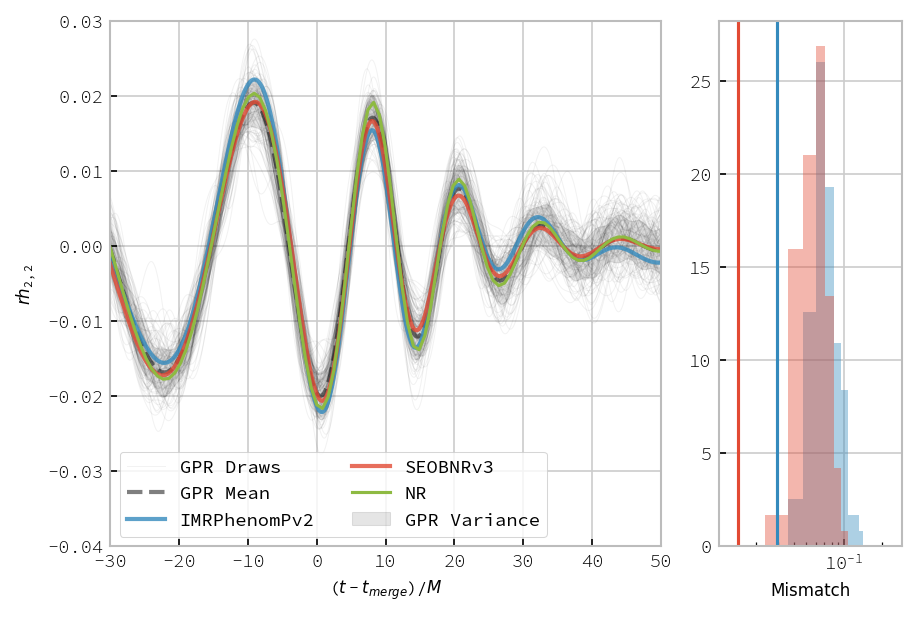

In [28]:
row = rows[rows['tag']=="GT0374"].to_dict(orient="record")[0]
p = {"mass ratio": row['mass_ratio'],
    "spin 1x": row['spin_1x'], "spin 1y": row['spin_1y'], "spin 1z": row['spin_1z'],
    "spin 2x": row['spin_2x'], "spin 2y": row['spin_2y'], "spin 2z": row['spin_2z']
    }

waveform = [x  for x in generator.catalogue.waveforms if x.tag == row['tag']][0]
wave = waveform.timeseries(total_mass=60, f_low=None, t_min=-0.015, t_max=0.02)[0]
f, ax = paper_plot(p=p.copy())
ax[0].plot(wave.times*time_factor, wave.data*h_factor, color="#8EBA42", label="NR")
ax[0].legend(prop=thesis.ssp_legend, ncol=2)
ax[0].set_ylim([-0.04, 0.03])
f.savefig("{}/heron/withnr.{}".format(fig_dir, fig_ext))

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/heron-stable/lib/python2.7/site-packages/george-0.3.1-py2.7-linux-x86_64.egg/george/utils.py:30: RuntimeWarning: covariance is not symmetric positive-semidefinite.


(0.9858805861938867, 0.9859788989042936)


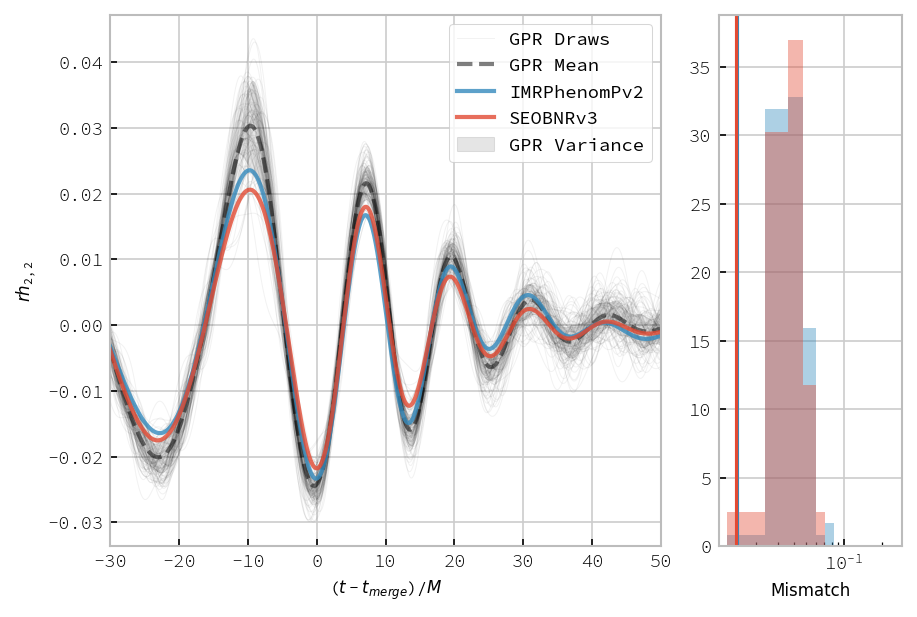

In [29]:
#generator.gp.set_parameter_vector(np.log(np.array([1.0    , 0.001538  , 0.0141315, 0.006    , 0.004    , 0.007    ,
#       0.007    , 0.005    , 0.005    ])))
f, ax = paper_plot(p={"mass ratio": 1.0, 
              "spin 1x":0., "spin 1y": 0., "spin 1z": 0., 
              "spin 2x":0., "spin 2y": 0., "spin 2z": 0.})
#ax[0].legend(prop=thesis.ssp_legend)
f.savefig("{}/heron/nonspin-equalmass.{}".format(fig_dir, fig_ext))

(0.9723096375709863, 0.9820210141528812)


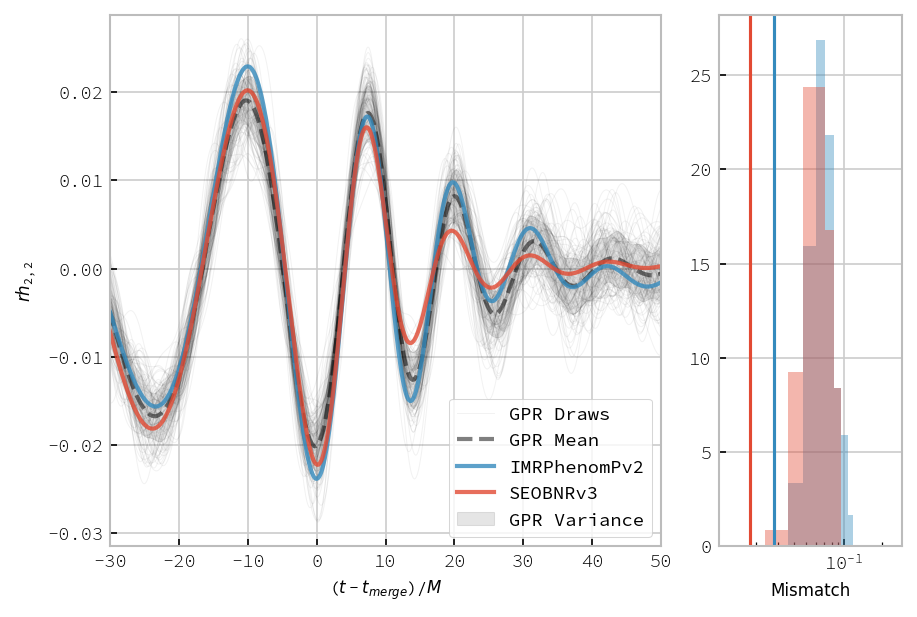

In [30]:
f, ax = paper_plot(p={"mass ratio": 1., "spin 1x":0., "spin 1y": 0., "spin 1z": 0.6, "spin 2x":0., "spin 2y": 0., "spin 2z": -0.6})
ax[0].legend(prop=thesis.ssp_legend)
f.savefig("{}/heron/antispin-equalmass.{}".format(fig_dir, fig_ext))

(0.9427378258771005, 0.8723783089173383)


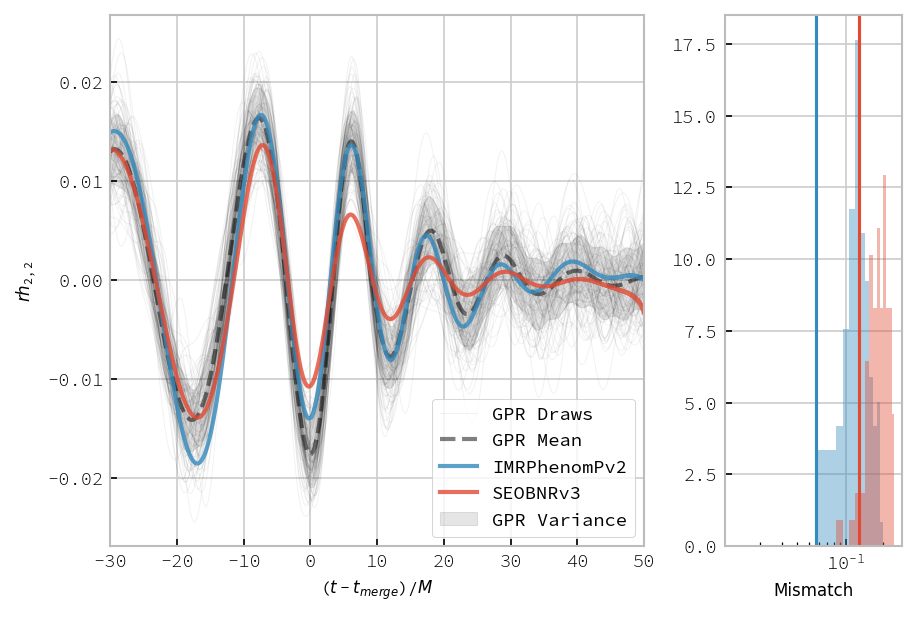

In [31]:
f, ax = paper_plot(p={"mass ratio": 0.4, 
                      "spin 1x":  -0.5,   "spin 1y":   -0.15,    "spin 1z": 0.3, 
                      "spin 2x":   0.5,    "spin 2y": 0.13,    "spin 2z": 0.3})
f.savefig("{}/heron/precessing.{}".format(fig_dir, fig_ext))